In [95]:
import pandas as pd

data = pd.read_csv('clustering_data.csv', dtype={'Latitude': str, 'Longitude': str})
STATE = "WEST BENGAL"
dataFiltered = data[data['StateName'] == STATE].copy()

print("Filtered shape for West Bengal:", dataFiltered.shape)

Filtered shape for West Bengal: (8775, 11)


In [96]:
dataFiltered['Latitude'] = pd.to_numeric(dataFiltered['Latitude'], errors='coerce')
dataFiltered['Longitude'] = pd.to_numeric(dataFiltered['Longitude'], errors='coerce')

dataFiltered.dropna(subset=['Latitude', 'Longitude'], inplace=True)
dataFiltered.drop_duplicates(subset=['Pincode', 'Latitude', 'Longitude'], inplace=True)

print("Cleaned data shape:", dataFiltered.shape)

min_lat, max_lat = 21.5, 27.5
min_lon, max_lon = 85.0, 89.9

# Filter based on lat-lon bounds
dataFiltered = dataFiltered[
    (dataFiltered['Latitude'] >= min_lat) & (dataFiltered['Latitude'] <= max_lat) &
    (dataFiltered['Longitude'] >= min_lon) & (dataFiltered['Longitude'] <= max_lon)
]

Cleaned data shape: (6654, 11)


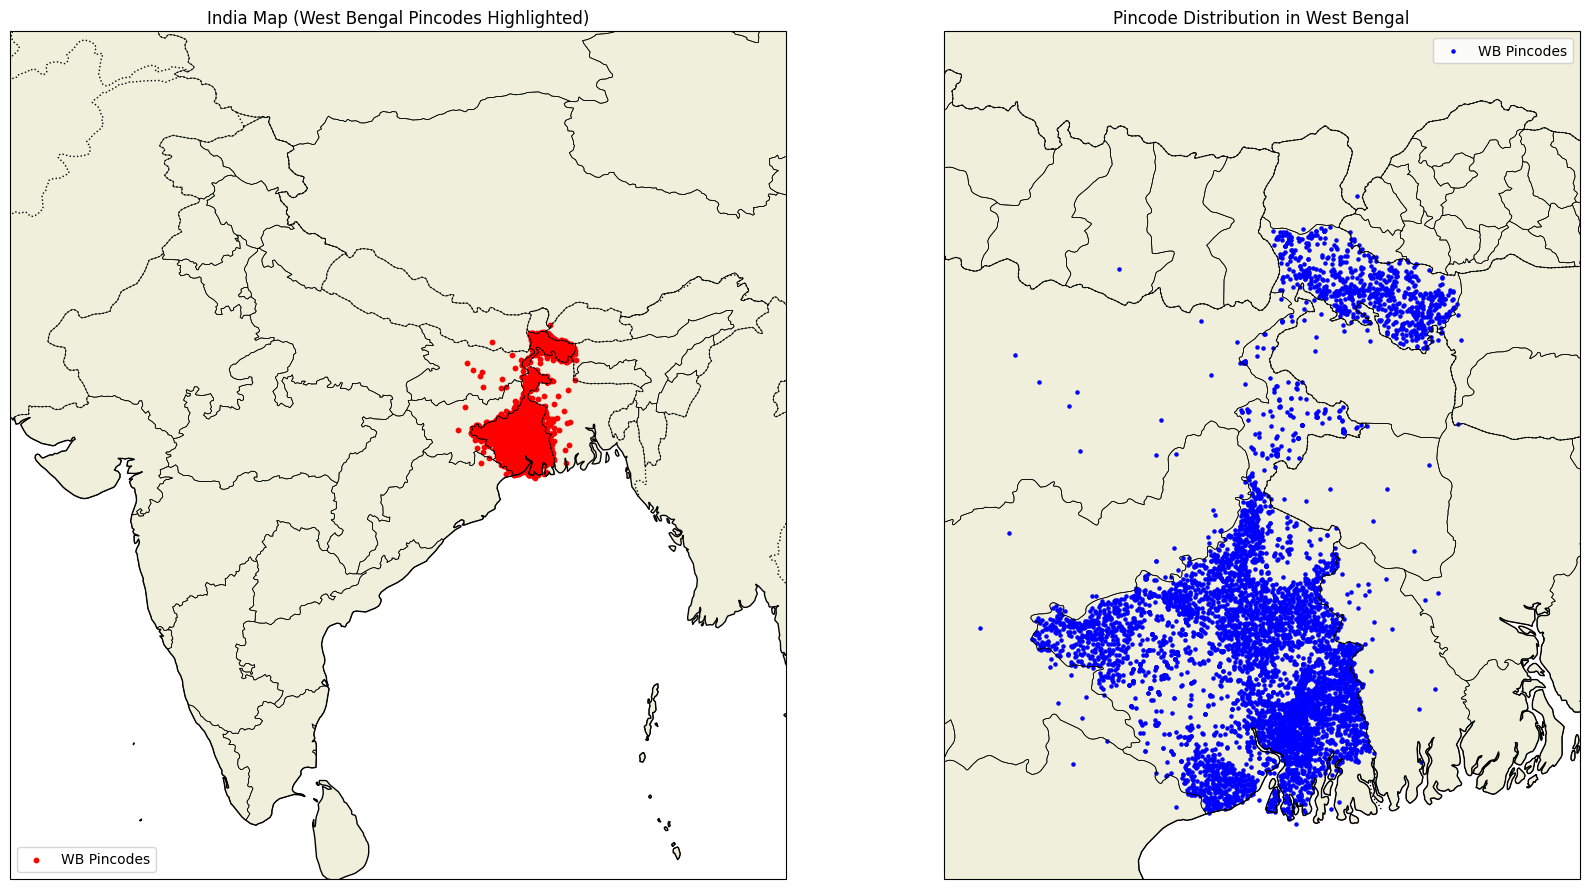

In [97]:
!pip install cartopy

import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Add features (land, borders, coastlines)
ax1.set_title("India Map (West Bengal Pincodes Highlighted)")
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.STATES, linewidth=0.5)
ax1.set_extent([68, 98, 6, 38])

# Plot the pincode points
ax1.scatter(dataFiltered['Longitude'], dataFiltered['Latitude'], color='red', s=10, label='WB Pincodes', transform=ccrs.PlateCarree())
ax1.legend(loc='lower left')

ax2.set_title("Zoomed-In View: West Bengal Pincodes")
ax2.add_feature(cfeature.LAND)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.STATES, linewidth=0.5)
ax2.set_extent([85, 91, 21, 29])

# Plot points for West Bengal
ax2.scatter(dataFiltered['Longitude'], dataFiltered['Latitude'], color='blue', s=5, label='WB Pincodes', transform=ccrs.PlateCarree())
ax2.legend(loc='lower left')

plt.title("Pincode Distribution in West Bengal")
plt.legend()
plt.tight_layout()
plt.show()

In [98]:
meanLongitude = dataFiltered['Longitude'].mean()
meanLatitude = dataFiltered['Latitude'].mean()

stdLongitude = dataFiltered['Longitude'].std()
stdLatitude = dataFiltered['Latitude'].std()

dataFilteredNormalized = dataFiltered.copy()

dataFilteredNormalized['Latitude'] = (dataFiltered['Latitude'] - meanLatitude) / stdLatitude
dataFilteredNormalized['Longitude'] = (dataFiltered['Longitude'] - meanLongitude) / stdLongitude

print("Normalized data shape:", dataFilteredNormalized.shape)

Normalized data shape: (6467, 11)


In [99]:
from math import e
import numpy as np

labelMap = {column: index for index,column in enumerate(dataFiltered)}

def distance(data, centroid):
  distances = []
  for i in data:
    distances.append(((i[labelMap['Longitude']] - centroid[0])**2 + (i[labelMap['Latitude']] - centroid[1])**2)**0.5)
  return distances

def kmeans(data, k, iterations=100, tolerance=1e-4):
  np.random.seed(69)
  centroids = data[np.random.choice(data.shape[0], k, replace=False)]
  centroids = centroids[:, [labelMap['Longitude'], labelMap['Latitude']]]

  for _ in range(iterations):

    distancesToCentroids = [distance(data, centroid) for centroid in centroids]

    distancesToPoints = np.array(distancesToCentroids).T

    labels = np.argmin(distancesToPoints, axis=1)

    updatedCentroids = []

    for clusterIndex in range(k):
      clusterPoints = data[labels == clusterIndex]
      clusterPoints = clusterPoints[:, [labelMap['Longitude'], labelMap['Latitude']]]

      if len(clusterPoints) > 0:
        updatedCentroid = np.mean(clusterPoints, axis=0)
      else:
        updatedCentroid = data[np.random.choice(data.shape[0])]
        updatedCentriod = updatedCentroid[:, [labelMap['Longitude'], labelMap['Latitude']]]

      updatedCentroids.append(updatedCentroid)

    updatedCentroids = np.array(updatedCentroids)

    centroidShift = np.linalg.norm(centroids - updatedCentroids)

    if np.max(centroidShift) <= tolerance:
      print(f"Converged after {_+1} iterations.")
      break

    centroids = updatedCentroids

  return centroids, labels


arrayData = dataFilteredNormalized.to_numpy()

centroids, labels = kmeans(arrayData, 5)

Converged after 23 iterations.


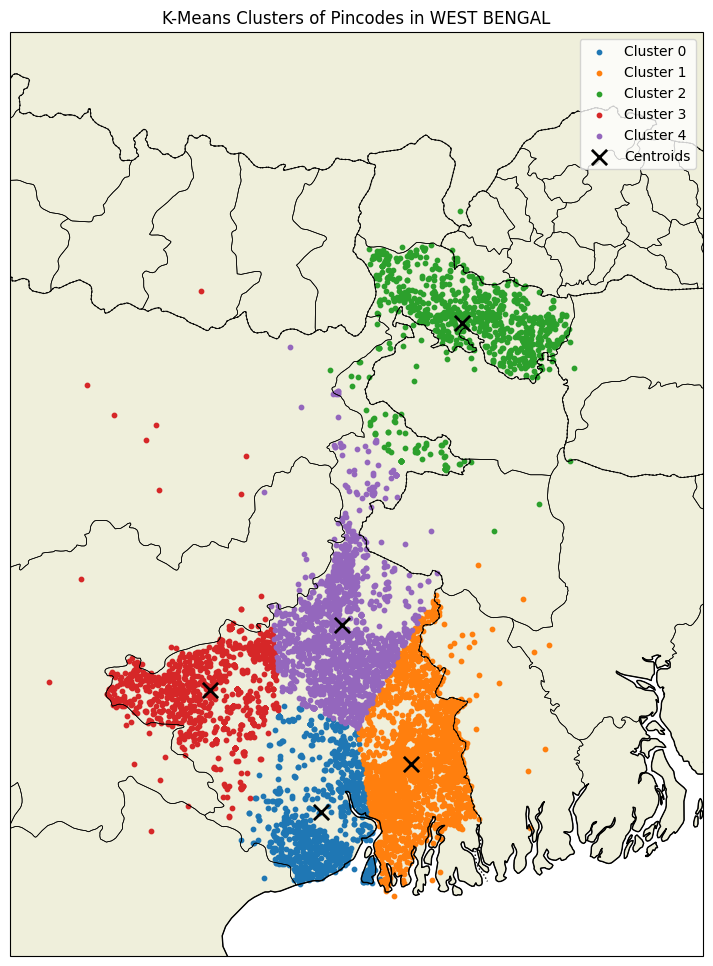

In [105]:
dataFiltered['Cluster'] = labels

def plotClusters(data, k, centroidList):

  fig = plt.figure(figsize=(12, 12))
  ax = plt.axes(projection=ccrs.PlateCarree())
  ax.add_feature(cfeature.LAND)
  ax.add_feature(cfeature.BORDERS, linestyle=':')
  ax.add_feature(cfeature.COASTLINE)
  ax.add_feature(cfeature.STATES, linewidth=0.5)
  ax.set_extent([85, 91, 21, 29])

  cmap = plt.colormaps.get_cmap('tab10')
  colors = [cmap(i) for i in range(k)]

  for clusterIndex in range(k):
    clusterPoints = data[data['Cluster'] == clusterIndex]
    ax.scatter(
        clusterPoints['Longitude'],
        clusterPoints['Latitude'],
        label=f"Cluster {clusterIndex}",
        s=10,
        color=colors[clusterIndex],
        transform=ccrs.PlateCarree()
    )

  centroidList = [[centroid[0] * stdLongitude + meanLongitude, centroid[1] * stdLatitude + meanLatitude] for centroid in centroidList]

  for index, centroid in enumerate(centroidList):
    ax.scatter(
        centroid[0], centroid[1],
        color='black',
        marker='x',
        s=120,
        linewidths=2,
        transform=ccrs.PlateCarree(),
        label=f"Centroids" if index == 0 else None
    )

  ax.set_title(f'K-Means Clusters of Pincodes in {STATE}')
  plt.legend()
  plt.show()

plotClusters(dataFiltered, 5, centroids)